In [1]:
fragments = [
    "N-34-37-D-b-1-3",
    "N-34-37-D-b-1-4",
    "N-34-37-D-b-3-2",
    "N-34-37-D-b-3-4",
    "N-34-37-D-b-3-3",
    "N-34-37-D-d-1-1",
    "N-34-37-D-d-1-3",
    "N-34-37-D-d-1-4",
    "N-34-37-D-d-2-3",
    "N-34-37-D-d-4-1",
]

In [2]:
from pathlib import Path

data_dir = Path("../data")

In [3]:
import geopandas as gpd

hel_gdansk_data_dir = data_dir / "raw" / "shapefile" / "emodnet" / "hel_gdansk_data"

gdf = gpd.read_file(hel_gdansk_data_dir / "coastal_type_20210501_0_80k.shp")

In [4]:
import laspy as lp
import numpy as np
from pyproj import Transformer
import os
from tqdm import tqdm

In [5]:
def transform_to_lonlat(dataset: np.array) -> np.array:
    """
    Convert coordinates from .las file to longitude and latitude.

    Args:
        dataset (np.array): Array of coordinates.

    Returns:
        np.array: Array of longitude and latitude coordinates.
    """

    source = "EPSG:2180"  # PL-1992 is the projection used in the dataset
    dest = "EPSG:4326"  # WGS84, the standard for GPS coordinates used all over the world

    # Create a transformer object
    transformer = Transformer.from_crs(source, dest, always_xy=True)

    x = dataset[:, 0]
    y = dataset[:, 1]
    z = dataset[:, 2]

    # Transform the coordinates
    lon, lat = transformer.transform(x, y)
    # Create a new array with the transformed coordinates
    transformed_coordinates = np.vstack((lon, lat, z)).T
    return transformed_coordinates

In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [10]:
from collections import defaultdict

in_no = defaultdict(int)

for prefix in fragments:
    if any(file.startswith(prefix) and file.endswith(".las") for file in os.listdir("../data/las")):
        in_no["in"] += 1
    else:
        in_no["not_in"] += 1

assert len(fragments) == in_no["in"], "Not all fragments are in the data"

<img src="imgs/zatoka_i_wladyslawowo.png" width="600"/>

In [16]:
final_df = pd.DataFrame(columns=["x", "y", "z", "coasttype"])
i = 0

data_path = Path("../data/las")

for prefix in tqdm(fragments):
    las_file = lp.read(data_path / f"{prefix}.las")
    dataset = np.vstack([las_file.x, las_file.y, las_file.z]).T
    transformed_dataset = transform_to_lonlat(dataset)
    lidar_df = pd.DataFrame(transformed_dataset, columns=["x", "y", "z"])
    lidar_df["geometry"] = [Point(xy) for xy in zip(lidar_df["x"], lidar_df["y"])]
    lidar_gdf = gpd.GeoDataFrame(lidar_df, geometry="geometry", crs=gdf.crs)
    lidar_gdf = lidar_gdf.to_crs(gdf.crs)
    merged_gdf = gpd.sjoin_nearest(
        lidar_gdf,
        gdf[["coasttype", "geometry"]],  # Only need coasttype and geometry
        how="left",
        distance_col="dist_to_line",
    )
    final_df = pd.concat([final_df, merged_gdf[["x", "y", "z", "coasttype"]]])

  0%|          | 0/10 [00:00<?, ?it/s]O:\studia\DataScienceMasters\10th_semester\lidar_classification\.venv\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\mikol\AppData\Local\Temp\ipykernel_2504\2118637052.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, merged_gdf[["x", "y", "z", "coasttype"]]])
 10%|█         | 1/10 [02:20<21:07, 140.80s/it]O:\studia\DataScienceMasters\10th_semester\lidar_classification\.venv\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. 

In [17]:
final_df.coasttype.value_counts()

coasttype
Muddy coastline, including tidal flat, salt marsh                                            28793527
Sand beach fronting upland (> 1 Km long)                                                     11819255
Beach that is part of extensive non-cohesive sedimentary systems (barrier, spit, tombolo)     9833295
Artificial beach                                                                              4048243
Beach, unspecified                                                                            1534388
Name: count, dtype: int64

In [98]:
# final_df.to_csv('final_df.csv', index=False)
final_df.shape

(56028708, 4)

In [99]:
tmp = pd.read_csv("final_df.csv")
tmp.shape

(56028708, 4)

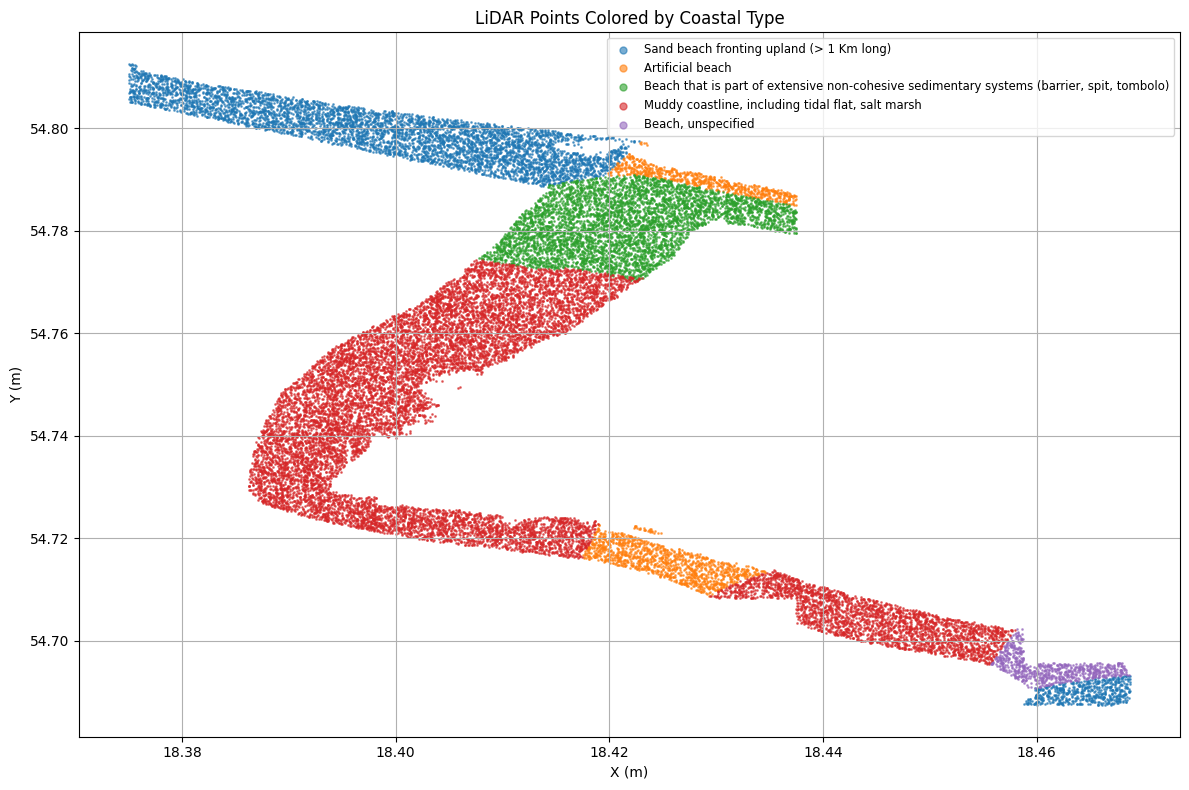

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for group in final_df.coasttype.unique():
    data = final_df.loc[final_df["coasttype"] == group].sample(frac=0.0005)
    plt.scatter(data["x"], data["y"], s=1, label=group, alpha=0.6)

plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("LiDAR Points Colored by Coastal Type")
plt.legend(markerscale=5, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

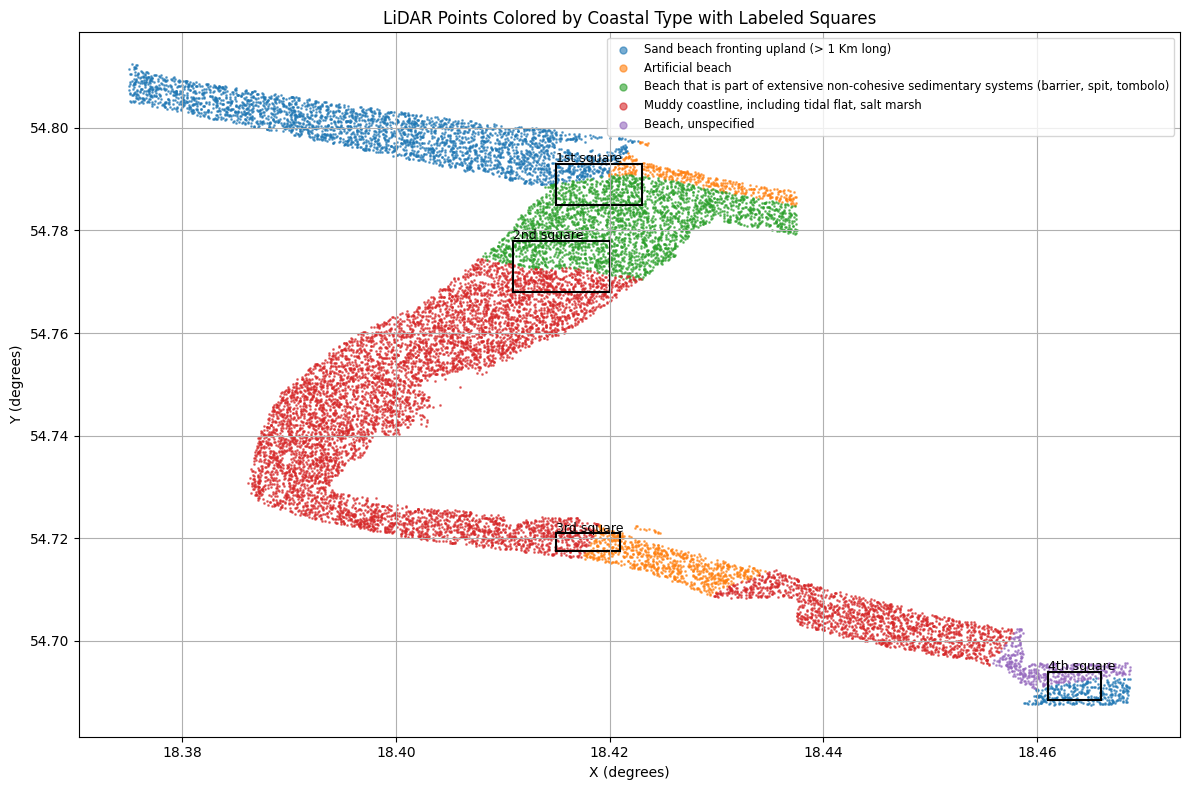

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(12, 8))

for group in final_df.coasttype.unique():
    data = final_df.loc[final_df["coasttype"] == group].sample(frac=0.0003)
    plt.scatter(data["x"], data["y"], s=1, label=group, alpha=0.6)

squares = [
    ([18.415, 54.785], [18.423, 54.793], "1st"),
    ([18.411, 54.768], [18.420, 54.778], "2nd"),
    ([18.415, 54.7175], [18.421, 54.721], "3rd"),
    ([18.461, 54.6885], [18.466, 54.694], "4th"),
]

for (x_min, y_min), (x_max, y_max), label in squares:
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1.5, edgecolor="black", facecolor="none")
    plt.gca().add_patch(rect)

    plt.text(x_min, y_max + 0.0003, f"{label} square", fontsize=9, color="black")

plt.xlabel("X (degrees)")
plt.ylabel("Y (degrees)")
plt.title("LiDAR Points Colored by Coastal Type with Labeled Squares")
plt.legend(markerscale=5, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
filtered_list = []

for (x_min, y_min), (x_max, y_max), label in squares:
    mask = (final_df["x"] >= x_min) & (final_df["x"] <= x_max) & (final_df["y"] >= y_min) & (final_df["y"] <= y_max)
    df_filtered = final_df[mask].copy()
    df_filtered["square_label"] = label
    filtered_list.append(df_filtered)

squares_df = pd.concat(filtered_list, ignore_index=True)

In [34]:
squares_df.shape

(5801209, 5)

In [35]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# def pointcloud_to_image(df, bins=128, save_path=None):
#     """
#     Converts x, y, z point cloud into a grayscale image.
#     Returns a 2D numpy array image of shape (bins, bins).
#     """
#     x = df['x'].values
#     y = df['y'].values
#     z = df['z'].values

#     # 2D histogram binning (elevation-based)
#     img, x_edges, y_edges = np.histogram2d(x, y, bins=bins, weights=z)
#     count, _, _ = np.histogram2d(x, y, bins=bins)
#     img = img / (count + 1e-6)  # average elevation per pixel

#     img = np.nan_to_num(img)
#     img = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalize [0, 1]
#     img = (img * 255).astype(np.uint8)  # convert to 8-bit grayscale

#     if save_path:
#         plt.imsave(save_path, img, cmap='gray')

#     return img

In [38]:
# import re

# def sanitize_coastal_type(coast_type: str) -> str:
#     return re.sub(r'[^a-zA-Z0-9]', '', coast_type)

# os.makedirs(data_path / "lidar_images", exist_ok=True)

# for label in squares_df["square_label"].unique():
#     sub_df = squares_df[squares_df["square_label"] == label]
#     for coasttype in sub_df["coasttype"].unique():
#         patch = sub_df[sub_df["coasttype"] == coasttype]
#         img = pointcloud_to_image(patch, save_path=data_path / f"lidar_images/{label}_{sanitize_coastal_type(coasttype)}.png")

In [40]:
# from torchvision import datasets, models, transforms
# import torch.nn as nn
# import torch

# # Define transforms
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# # Create dataset
# dataset = datasets.ImageFolder(root=data_path / 'lidar_images', transform=transform)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# # Load pre-trained ResNet
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))  # adjust output layer

# # Training loop (basic)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# for epoch in range(10):
#     for images, labels in train_loader:
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

ModuleNotFoundError: No module named 'torch'

In [41]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# Define tile size in degrees (~100m is around 0.001 deg at Polish latitude)
tile_size = 0.001

# Get min/max bounds
x_min, x_max = final_df["x"].min(), final_df["x"].max()
y_min, y_max = final_df["y"].min(), final_df["y"].max()

tiles = []
tile_geoms = []

x_coords = np.arange(x_min, x_max, tile_size)
y_coords = np.arange(y_min, y_max, tile_size)

for x0 in x_coords:
    for y0 in y_coords:
        x1, y1 = x0 + tile_size, y0 + tile_size
        tile_geom = box(x0, y0, x1, y1)
        tile_geoms.append(tile_geom)
        tiles.append(((x0, x1), (y0, y1)))

In [65]:
x_min, x_max, y_min, y_max

(np.float64(18.375000070039242),
 np.float64(18.468750072871966),
 np.float64(54.687500057592054),
 np.float64(54.81250003429658))

In [42]:
tile_gdf = gpd.GeoDataFrame(geometry=tile_geoms, crs="EPSG:4326")
joined = gpd.sjoin(tile_gdf, gdf[["geometry", "coasttype"]], how="left", predicate="intersects")

# Drop tiles with no coastal type (NaNs)
labeled_tiles = joined.dropna(subset=["coasttype"])

In [47]:
import os

os.makedirs("lidar_rasters", exist_ok=True)


def sanitize_coastal_type(coast_type: str) -> str:
    return re.sub(r"[^a-zA-Z0-9]", "", coast_type)


def generate_tile_image(df, x_range, y_range, bins=128):
    x_mask = (df["x"] >= x_range[0]) & (df["x"] <= x_range[1])
    y_mask = (df["y"] >= y_range[0]) & (df["y"] <= y_range[1])
    patch = df[x_mask & y_mask]
    if patch.empty:
        return None
    return pointcloud_to_image(patch, bins=bins)


# Loop through labeled tiles
for idx, row in labeled_tiles.iterrows():
    x_range = (row.geometry.bounds[0], row.geometry.bounds[2])
    y_range = (row.geometry.bounds[1], row.geometry.bounds[3])
    coasttype = row["coasttype"].replace(" ", "_").lower()

    img = generate_tile_image(final_df, x_range, y_range)
    if img is not None:
        fname = f"lidar_rasters/{idx}_{sanitize_coastal_type(coasttype)}.png"
        plt.imsave(fname, img, cmap="gray")

### Retrieve plots of raster imgs

In [48]:
tiles_to_plot = []  # list of (image_array, (x_min, x_max, y_min, y_max))

In [66]:
labeled_tiles

,geometry,index_right,coasttype
123,"POLYGON ((18.376 54.8105, 18.376 54.8115, 18.3...",16.0,Sand beach fronting upland (> 1 Km long)
248,"POLYGON ((18.377 54.8105, 18.377 54.8115, 18.3...",16.0,Sand beach fronting upland (> 1 Km long)
372,"POLYGON ((18.378 54.8095, 18.378 54.8105, 18.3...",16.0,Sand beach fronting upland (> 1 Km long)
373,"POLYGON ((18.378 54.8105, 18.378 54.8115, 18.3...",16.0,Sand beach fronting upland (> 1 Km long)
497,"POLYGON ((18.379 54.8095, 18.379 54.8105, 18.3...",16.0,Sand beach fronting upland (> 1 Km long)
...,...,...,...
11633,"POLYGON ((18.469 54.6955, 18.469 54.6965, 18.4...",52.0,"Beach, unspecified"
11634,"POLYGON ((18.469 54.6965, 18.469 54.6975, 18.4...",52.0,"Beach, unspecified"
11709,"POLYGON ((18.469 54.7715, 18.469 54.7725, 18.4...",37.0,Beach that is part of extensive non-cohesive s...
11712,"POLYGON ((18.469 54.7745, 18.469 54.7755, 18.4...",13.0,Artificial beach


In [49]:
for idx, row in labeled_tiles.iterrows():
    x0, y0, x1, y1 = row.geometry.bounds
    coasttype = row["coasttype"].replace(" ", "_").lower()

    img = generate_tile_image(final_df, (x0, x1), (y0, y1))
    if img is not None:
        tiles_to_plot.append((img, (x0, x1, y0, y1)))

100%|██████████| 323/323 [00:00<00:00, 3845.27it/s]


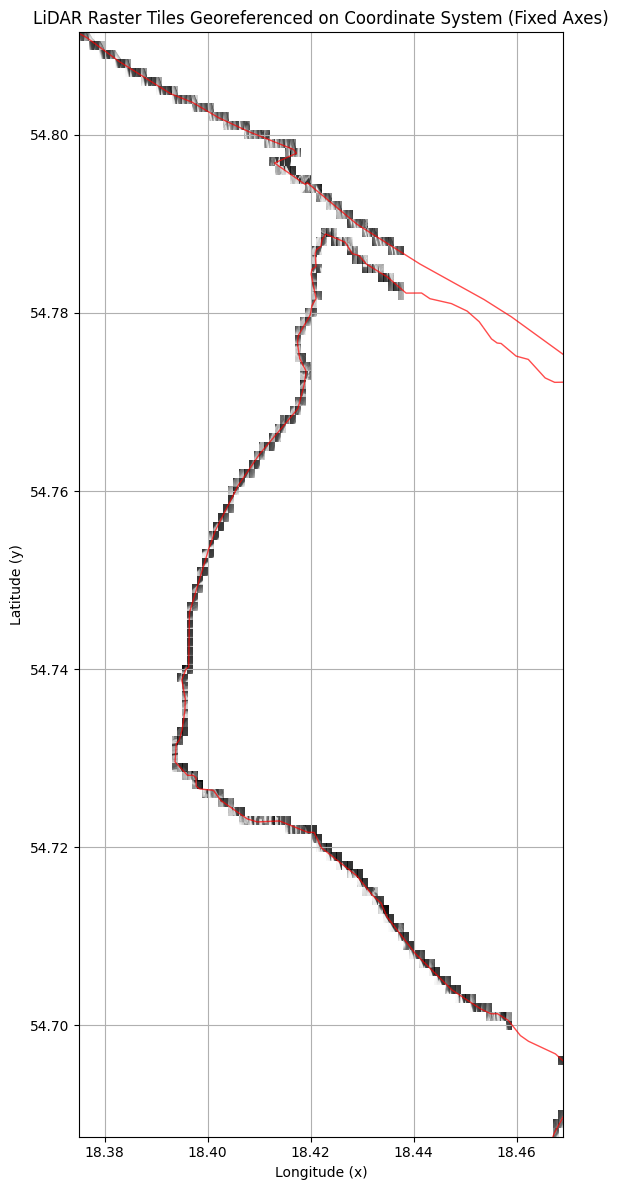

In [97]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Step 1: Compute global bounds
all_x0 = [extent[0] for _, extent in tiles_to_plot]
all_x1 = [extent[1] for _, extent in tiles_to_plot]
all_y0 = [extent[2] for _, extent in tiles_to_plot]
all_y1 = [extent[3] for _, extent in tiles_to_plot]

min_x, max_x = min(all_x0), max(all_x1)
min_y, max_y = min(all_y0), max(all_y1)

fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

for img, (x0, x1, y0, y1) in tqdm(tiles_to_plot):
    ax.imshow(img, extent=(x0, x1, y0, y1), origin="lower", cmap="gray", alpha=0.8)

gdf.plot(ax=ax, edgecolor="red", linewidth=1, facecolor="none", alpha=0.7)

ax.set_xlabel("Longitude (x)")
ax.set_ylabel("Latitude (y)")
ax.set_title("LiDAR Raster Tiles Georeferenced on Coordinate System (Fixed Axes)")
ax.grid(True)
plt.tight_layout()
plt.show()

In [100]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

dataset = datasets.ImageFolder(root=data_path / "lidar_images", transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))  # adjust output layer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

FileNotFoundError: Couldn't find any class folder in ..\data\las\lidar_images.

In [101]:
import os
from pathlib import Path

output_dir = Path("lidar_images_torch")
output_dir.mkdir(parents=True, exist_ok=True)

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def create_histogram_image(x, y, bins=256, range_=None):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range_)
    heatmap = np.flipud(heatmap.T)
    heatmap = (heatmap / heatmap.max() * 255).astype(np.uint8)
    return Image.fromarray(heatmap)

In [105]:
for coasttype in final_df["coasttype"].unique():
    org_coasttype = coasttype
    coasttype = sanitize_coastal_type(coasttype)
    class_dir = output_dir / coasttype
    class_dir.mkdir(parents=True, exist_ok=True)

    subset = final_df[final_df["coasttype"] == org_coasttype]
    x = subset["x"].values
    y = subset["y"].values

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    range_ = [[x_min, x_max], [y_min, y_max]]

    img = create_histogram_image(x, y, bins=256, range_=range_)
    img.save(class_dir / f"{coasttype}.png")

In [112]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define transforms
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Load the dataset
dataset = datasets.ImageFolder(root=output_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [113]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [114]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [117]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    if val_total > 0:
        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")
    else:
        val_epoch_loss = 0
        val_epoch_acc = 0
        print("Warning: Metrics on validation data not available.")

Epoch 1/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 2/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 3/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 4/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 5/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 6/50, Loss: 0.0000, Accuracy: 1.0000
Validation Loss: 0.0000, Validation Accuracy: 0.0000
Epoch 7/50, Loss: 0.0000, Accuracy: 1.0000


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=dataset.classes))

In [126]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# Define tile size in degrees (~100m is around 0.0009° at Polish latitude)
tile_size = 0.0009

x_min, x_max = final_df["x"].min(), final_df["x"].max()
y_min, y_max = final_df["y"].min(), final_df["y"].max()

tiles = []
tile_geoms = []

x_coords = np.arange(x_min, x_max, tile_size)
y_coords = np.arange(y_min, y_max, tile_size)

for x0 in x_coords:
    for y0 in y_coords:
        x1, y1 = x0 + tile_size, y0 + tile_size
        tile_geom = box(x0, y0, x1, y1)
        tile_geoms.append(tile_geom)
        tiles.append(((x0, x1), (y0, y1)))

tile_gdf = gpd.GeoDataFrame(geometry=tile_geoms, crs="EPSG:4326")

joined = gpd.sjoin(tile_gdf, gdf[["geometry", "coasttype"]], how="left", predicate="intersects")

# Drop tiles with no coastal type (NaNs)
labeled_tiles = joined.dropna(subset=["coasttype"])

Exception in thread Exception ignored in: <function _ConnectionBase.__del__ at 0x000001D8E772DA80>
Traceback (most recent call last):
  File "C:\Python312\Lib\multiprocessing\connection.py", line 133, in __del__
QueueFeederThread:
Traceback (most recent call last):
  File "C:\Python312\Lib\multiprocessing\queues.py", line 259, in _feed
    self._close()
  File "C:\Python312\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
    reader_close()
OSError: [WinError 6] The handle is invalid
  File "C:\Python312\Lib\multiprocessing\connection.py", line 178, in close
    self._close()
  File "C:\Python312\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Python312\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "O:\studia\DataScienceMasters

In [127]:
import numpy as np
import matplotlib.pyplot as plt


def pointcloud_to_image(df, bins=128):
    """
    Converts x, y, z point cloud into a grayscale image.
    Returns a 2D numpy array image of shape (bins, bins).
    """
    x = df["x"].values
    y = df["y"].values
    z = df["z"].values

    # 2D histogram binning (elevation-based)
    img, x_edges, y_edges = np.histogram2d(x, y, bins=bins, weights=z)
    count, _, _ = np.histogram2d(x, y, bins=bins)
    img = img / (count + 1e-6)  # average elevation per pixel

    img = np.nan_to_num(img)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalize [0, 1]
    img = (img * 255).astype(np.uint8)  # convert to 8-bit grayscale

    return img

In [129]:
import os
import matplotlib.pyplot as plt
import re

base_dir = "lidar_rasters"
os.makedirs(base_dir, exist_ok=True)


def sanitize_coastal_type(coast_type: str) -> str:
    """Sanitize the coastal type string to be filesystem-friendly."""
    return re.sub(r"[^a-zA-Z0-9]", "", coast_type)


for idx, row in labeled_tiles.iterrows():
    x_range = (row.geometry.bounds[0], row.geometry.bounds[2])
    y_range = (row.geometry.bounds[1], row.geometry.bounds[3])
    coasttype = sanitize_coastal_type(row["coasttype"])

    class_dir = os.path.join(base_dir, coasttype)
    os.makedirs(class_dir, exist_ok=True)

    img_filename = f"{idx}_{sanitize_coastal_type(coasttype)}.png"
    img_path = os.path.join(class_dir, img_filename)

    # Filter point cloud data for the current tile
    x_mask = (final_df["x"] >= x_range[0]) & (final_df["x"] <= x_range[1])
    y_mask = (final_df["y"] >= y_range[0]) & (final_df["y"] <= y_range[1])
    patch = final_df[x_mask & y_mask]

    if not patch.empty:
        img = pointcloud_to_image(patch)

        plt.imsave(img_path, img, cmap="gray")